In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam
from keras.applications import VGG16
from keras.regularizers import l2
from keras.applications.vgg16 import preprocess_input
from sklearn import svm
from sklearn.externals import joblib
import pickle
import time

Using TensorFlow backend.


In [2]:
def preprocess(x):
    mean = np.mean(x, axis=(1, 2, 3), keepdims=True)
    x -= mean
    return x

def mirror(x):
    mirror_x = x[..., ::-1, :]
    return np.vstack([x, mirror_x])

train_X, train_y, val_X, val_y, test_X, test_y = np.load("data.npy")
train_X, val_X, test_X = preprocess(train_X), preprocess(val_X), preprocess(test_X)
train_X = mirror(train_X)
train_y = np.vstack([train_y, train_y])
nb_class = 7
p_dropout = 0.2

In [3]:
model = load_model('tl_models/tl28')

In [5]:
def test(model, x, y):
    pred = model.predict(x)
    pred_y = np.argmax(pred, axis=1)
    y = np.argmax(y, axis=1)
    return np.mean(y == pred_y)

test(model, test_X, test_y)

0.65672889384229594

In [6]:
model_output = model.layers[-3].output
model_feat = Model(input = model.input, output=model_output)

In [7]:
print(model_feat.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_input_1 (InputLaye (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 48, 48, 3)     30          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 48, 48, 3)     0           convolution2d_34[0][0]           
____________________________________________________________________________________________________
convolution2d_35 (Convolution2D) (None, 48, 48, 64)    1792        activation_37[0][0]              
___________________________________________________________________________________________

In [8]:
train_features = model_feat.predict(train_X)
val_features = model_feat.predict(val_X)
test_features = model_feat.predict(test_X)

In [11]:
def transformY(train_y):
    svm_y = []
    for y in train_y:
        for i, bit in enumerate(y):
            if bit == 1:
                svm_y.append(i)
    return np.array(svm_y)

svm_train_y = transformY(train_y)
svm_val_y = transformY(val_y)
svm_test_y = transformY(test_y)

In [20]:
clf = svm.SVC(C=10, probability=True)
clf.fit(train_features, svm_train_y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
y_pred = clf.predict_proba(val_features)
# acc = np.mean(y_pred == svm_val_y)
# print(acc)

In [11]:
def eval_acc(y, y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    return np.mean(y == y_pred)

In [12]:
eval_acc(svm_val_y, y_pred)

0.67790470883254383

In [24]:
y_pred = clf.predict_proba(test_features)
eval_acc(svm_test_y, y_pred)

0.66425188074672614

In [21]:
train_features.shape

(57418, 512)

In [8]:
layer = 30
model_output = model.layers[layer].output
model_output = MaxPooling2D((2, 2), strides=(2, 2))(model_output)
model_output = Flatten()(model_output)
model_feat = Model(input=model.input, output=model_output)
print(model_feat.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_input_1 (InputLaye (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 48, 48, 3)     30          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 48, 48, 3)     0           convolution2d_34[0][0]           
____________________________________________________________________________________________________
convolution2d_35 (Convolution2D) (None, 48, 48, 64)    1792        activation_37[0][0]              
___________________________________________________________________________________________

In [9]:
C = 1

print('predicting')
train_features = model_feat.predict(train_X)
val_features = model_feat.predict(val_X)
test_features = model_feat.predict(test_X)
print('done')

predicting


In [12]:
print('training SVM')
t = time.time()
clf = svm.SVC(C=C, probability=True, max_iter=1)
clf.fit(train_features, svm_train_y)
print(time.time() - t)

training SVM
76.9887204170227


C:\Users\dilu\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [38]:
intermediate_output = model.layers[20].output
intermediate_layer_model = Model(input=model.input, output=intermediate_output)
print(intermediate_layer_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_input_1 (InputLaye (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 48, 48, 3)     30          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 48, 48, 3)     0           convolution2d_34[0][0]           
____________________________________________________________________________________________________
convolution2d_35 (Convolution2D) (None, 48, 48, 64)    1792        activation_37[0][0]              
___________________________________________________________________________________________

In [39]:
intermediate_output = intermediate_layer_model.predict(train_X[:1, ..., :1])

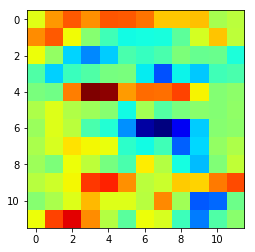

In [44]:
plt.imshow(intermediate_output[0, ..., 3], cmap='jet')
plt.show()

In [41]:
intermediate_output.shape

(1, 12, 12, 256)

In [45]:
def plot_weight(intermediate_output):
    n = intermediate_output.shape[-1]
    row = col = np.sqrt(n)
    if row % 1 != 0:
        row = np.sqrt(n / 2)
        col = 2 * row
    row, col = int(row), int(col)
    fig, ax = plt.subplots(row, col)
    for i in range(n):
        r, c = i // col, i % col
        ax[r, c].imshow(intermediate_output[0, :, :, i], cmap='jet')
        ax[r, c].axis('off')

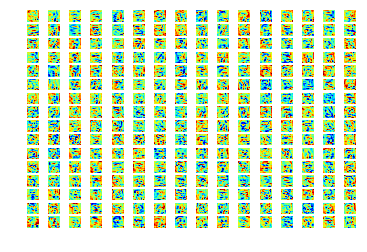

In [46]:
plot_weight(intermediate_output[..., :])
plt.show()

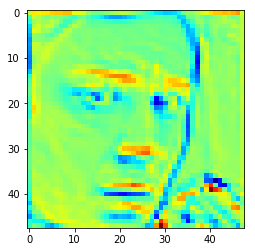

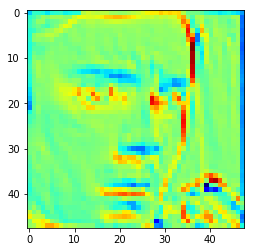

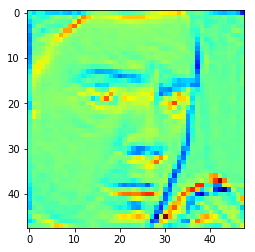

In [74]:
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(index=1).output)
intermediate_output = intermediate_layer_model.predict(train_X[:1, ..., :1])

plt.imshow(intermediate_output[0, ..., 0], cmap='jet')
plt.show()
plt.imshow(intermediate_output[0, ..., 1], cmap='jet')
plt.show()
plt.imshow(intermediate_output[0, ..., 2], cmap='jet')
plt.show()

In [76]:
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(index=32).output)
intermediate_output = intermediate_layer_model.predict(train_X[:1, ..., :1])
print(intermediate_layer_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_input_1 (InputLaye (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 48, 48, 3)     30          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 48, 48, 3)     0           convolution2d_34[0][0]           
____________________________________________________________________________________________________
convolution2d_35 (Convolution2D) (None, 48, 48, 64)    1792        activation_37[0][0]              
___________________________________________________________________________________________

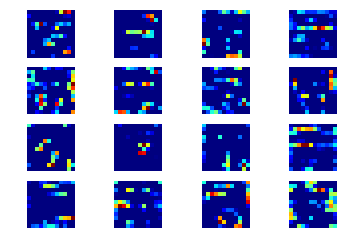

In [78]:
plot_weight(intermediate_output[..., :16])
plt.show()